# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [128]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed
import scipy.stats as stats
import seaborn as sns
import keras_tuner as kt
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

### Define functions

In [129]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [130]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [131]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [132]:
# define the number of rows and columns in the dataframe
rows, col = df.shape

# print the number of rows and columns of the dataframe
print(f"The number of columns in the dataset: {col}")
print(f"The number of rows in the dataset: {rows}")

# get a list of the column names
col_names = list(df.columns)

# print the column names
print(f"The column names of the dataset:")
for name in col_names: print(f"\t{name}")

# list of number of unique values in each column in the dataframe
uniq = df.nunique()

# print unique value count
print(f"\nUnique values for each column in dataset: \n{uniq}")

# get each unique value for column 'cocoa_percent'
cocoa_uniq = df['cocoa_percent'].unique()
cocoa_uniq.sort()

# print all unique 'cocoa_percent' values
print("\nAll unique cocoa_percent values:")
for value in cocoa_uniq:
    print(f"\t{value}")

The number of columns in the dataset: 9
The number of rows in the dataset: 1795
The column names of the dataset:
	maker
	specific_origin
	reference_number
	review_date
	cocoa_percent
	maker_location
	rating
	bean_type
	broad_origin

Unique values for each column in dataset: 
maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64

All unique cocoa_percent values:
	42.0
	46.0
	50.0
	53.0
	55.0
	56.0
	57.0
	58.0
	60.0
	60.5
	61.0
	62.0
	63.0
	64.0
	65.0
	66.0
	67.0
	68.0
	69.0
	70.0
	71.0
	72.0
	72.5
	73.0
	73.5
	74.0
	75.0
	76.0
	77.0
	78.0
	79.0
	80.0
	81.0
	82.0
	83.0
	84.0
	85.0
	86.0
	87.0
	88.0
	89.0
	90.0
	91.0
	99.0
	100.0


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [133]:
# determine the number of levels
num_levels = 8
    
# define the data bounds for quantization
min_value = np.min(df["cocoa_percent"])
max_value = np.max(df["cocoa_percent"])

# Calculate the step size
step_size = np.ceil((max_value - min_value) / num_levels)

# Define the labels for each level based on the specified boundaries
# labels = ['Sweet', 'Semi-sweet', 'Bittersweet', 'Extra dark', 'Unsweetened']
labels = ['Level 1', 'Level 2','Level 3', 'Level 4', 'Level 5', 'Level 6', 'Level 7', 'Level 8']

# Generate dynamic boundaries using the step size
boundaries = [min_value + step_size * i for i in range(num_levels + 1)]
print("Boundaries for quantization:", boundaries)

# # Define the boundaries for quantization
# boundaries = [0, 60, 70, 86, 100]

# # Create a new column for the quantized classes
# def categorize_cocoa_percent(value):
#     if value < boundaries[1]:
#         return 1  # Sweet
#     elif boundaries[1] <= value < boundaries[2]:
#         return 2  # Semi-sweet
#     elif boundaries[2] <= value < boundaries[3]:
#         return 3  # Bittersweet
#     elif boundaries[3] <= value < boundaries[4]:
#         return 4  # Extra dark
#     else:
#         return 5  # Unsweetened

# Apply categorization to the cocoa_percent column
# df['cocoa_class'] = df['cocoa_percent'].apply(categorize_cocoa_percent)

# Create a new column for the quantized classes
def categorize_cocoa_percent(value):
    for i in range(num_levels):
        if boundaries[i] <= value < boundaries[i + 1]:
            return i + 1  # Assign the appropriate category (1-based index)
    return num_levels  # If value equals the max_value, assign to the last category

# Apply categorization to the cocoa_percent column
df['cocoa_class'] = df['cocoa_percent'].apply(categorize_cocoa_percent)

# Map the numeric classes to their corresponding labels
df['cocoa_label'] = df['cocoa_class'].map(lambda x: labels[x-1])

# Display the DataFrame with the new category column
print(df[['cocoa_percent', 'cocoa_class', 'cocoa_label']].head())

# Create dataframe with outcome variable
# Thought about using the `cocoa_label` variable but it may be easier to use the ordinal numerical scale
Y = df[['cocoa_class']]

Boundaries for quantization: [42.0, 50.0, 58.0, 66.0, 74.0, 82.0, 90.0, 98.0, 106.0]
   cocoa_percent  cocoa_class cocoa_label
0          63.00            3     Level 3
1          70.00            4     Level 4
2          70.00            4     Level 4
3          70.00            4     Level 4
4          70.00            4     Level 4


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

   review_date  rating
0         2016    3.75
1         2015    2.75
2         2015    3.00
3         2015    3.50
4         2015    3.50


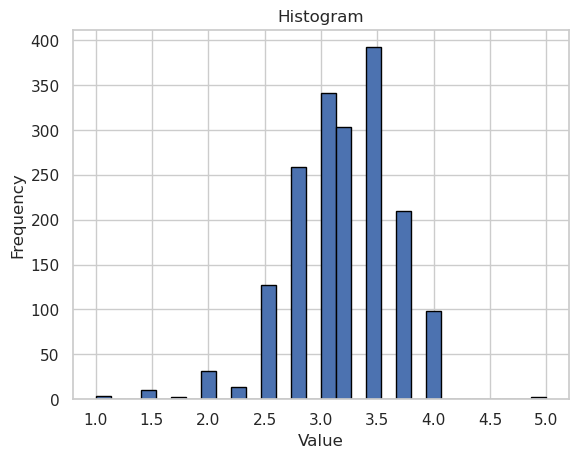

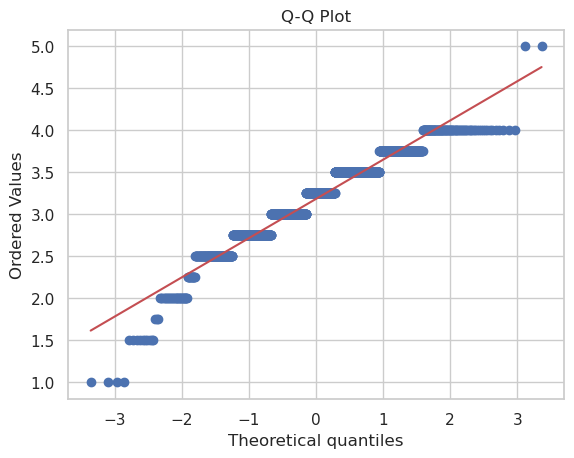

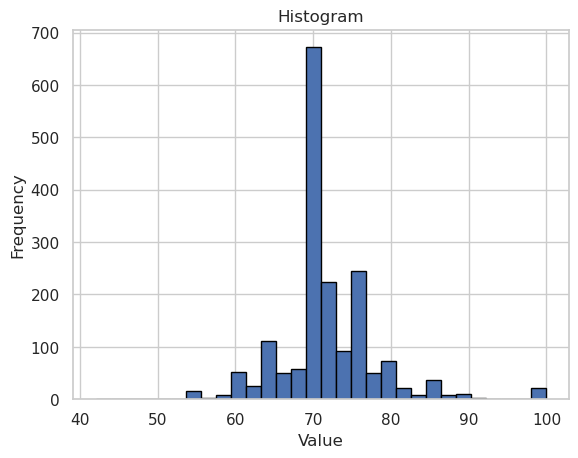

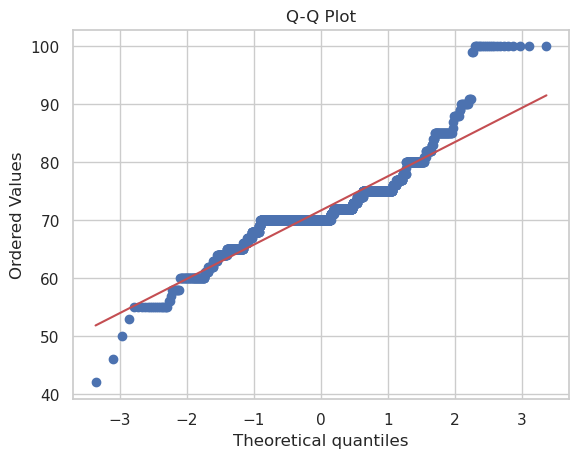

In [134]:
np.random.seed(0)
# 3. Identify features of interest
features_of_interest = [
    # "maker",
	# "specific_origin",
    # "cocoa_label",
	# "reference_number", # doesn't seem to be relevant to the predictive model (contextual knowledge)
	"review_date",
	# "maker_location",
	"rating",
	# "bean_type",
	# "broad_origin"
    ]

X = df[features_of_interest]
print(X.head())

# 4. Clean data
# 4a. Drop NAs
X_clean = X[features_of_interest].dropna()
Y_clean = Y.dropna()

# 4b. Standardization of numerical values

# 4b.1 check if follows normal distribution
# histogram of rating
plt.hist(df['rating'], bins=30, edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of rating
stats.probplot(df['rating'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# histogram of cocoa_percent
plt.hist(df['cocoa_percent'], bins=30, edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of rating
stats.probplot(df['cocoa_percent'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


Neither the 'cocoa_percent' nor the 'rating' data is normal, however it may still be of use to standardize the data.

In [135]:
# 1a. Create list of indices corresponding to the rows in the dataset
indices = np.arange(X_clean.shape[0])

# 1b. Shuffle indices
shuffled_indices = np.random.permutation(indices)

# 1c. Change the ordering of the datasets based on shuffles_indices
# df_shuffled = df_clean.iloc[shuffled_indices].reset_index(drop=True)
X_shuffled = X_clean.iloc[shuffled_indices].reset_index(drop=True)
Y_shuffled = Y_clean.iloc[shuffled_indices].reset_index(drop=True)

# 2a. Test train split
X_train, X_val, Y_train, Y_val = train_test_split(X_shuffled, Y_shuffled, test_size= 0.4 , random_state= 1234)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size= 0.5 , random_state= 1234)

# 2b. Printing the shape of each array
print(f"Features Training dataframe shape: {X_train.shape}")
print(f"Features Validation dataframe shape: {X_val.shape}")
print(f"Features Test dataframe shape: {X_test.shape}")

print(f"Outcome Training dataframe shape: {Y_train.shape}")
print(f"Outcome Validation dataframe shape: {Y_val.shape}")
print(f"Outcome Test dataframe shape: {Y_test.shape}")

# 4b.2 Standardize the data for rating (continuous data)
rating_mean = X_train["rating"].mean()
rating_std = X_train["rating"].std()

X_train["rating_std"] = (X_train["rating"] - rating_mean) / rating_std
X_val["rating_std"] = (X_val["rating"] - rating_mean) / rating_std
X_test["rating_std"] = (X_test["rating"] - rating_mean) / rating_std

# drop original rating (non-standardized)
X_train = X_train.drop('rating', axis=1)
X_val = X_val.drop('rating', axis=1)
X_test = X_test.drop('rating', axis=1)

Features Training dataframe shape: (1077, 2)
Features Validation dataframe shape: (359, 2)
Features Test dataframe shape: (359, 2)
Outcome Training dataframe shape: (1077, 1)
Outcome Validation dataframe shape: (359, 1)
Outcome Test dataframe shape: (359, 1)


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

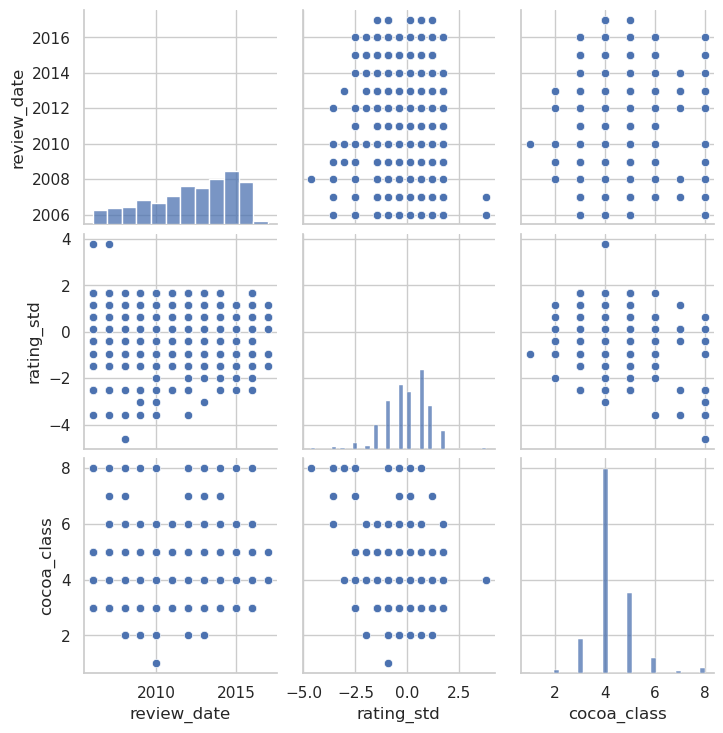

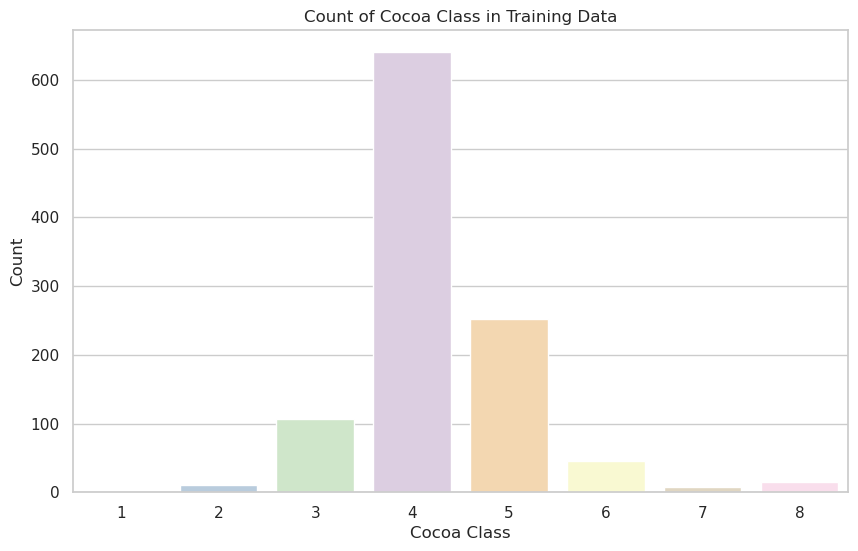

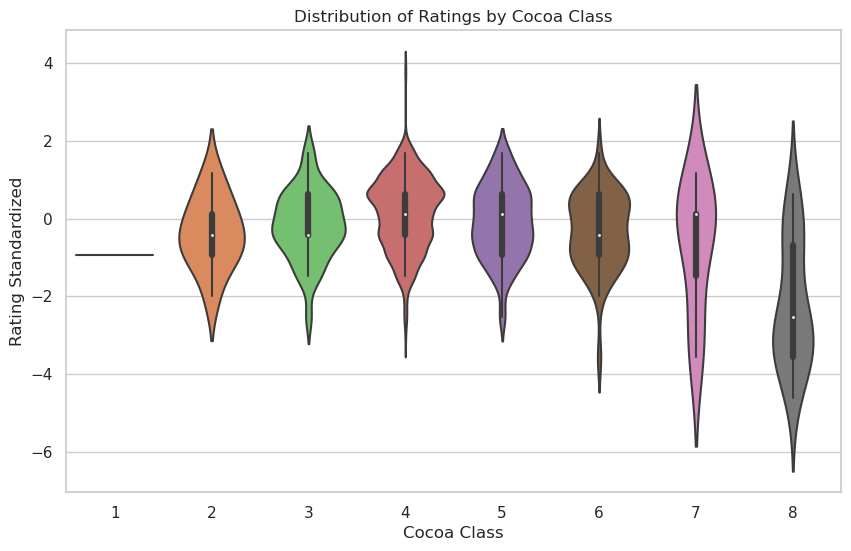

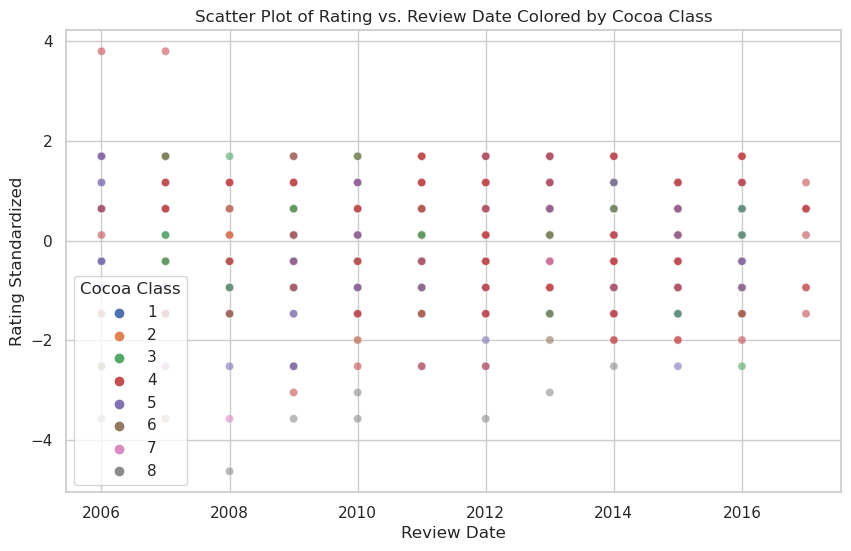

In [136]:

# Combine the training dataframes
training_df = pd.concat([X_train, Y_train], axis=1)

# 1. Create pairplot
sns.pairplot(training_df)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# 2. Count Plot for Cocoa Labels
plt.figure(figsize=(10, 6))
sns.countplot(x='cocoa_class', data=training_df, palette='Pastel1')
plt.title('Count of Cocoa Class in Training Data')
plt.xlabel('Cocoa Class')
plt.ylabel('Count')
# plt.legend(title ='Cocoa Class', loc='best') 
plt.show()

# 3. Violin Plot for Rating by Cocoa Label
plt.figure(figsize=(10, 6))
sns.violinplot(x='cocoa_class', y='rating_std', data=training_df, palette='muted')
plt.title('Distribution of Ratings by Cocoa Class')
plt.xlabel('Cocoa Class')
plt.ylabel('Rating Standardized')
plt.show()

# 4. Scatter Plot of review_date vs. Rating Colored by Cocoa Label
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_date', y='rating_std', hue='cocoa_class', data=training_df, alpha=0.6, palette='deep')
plt.title('Scatter Plot of Rating vs. Review Date Colored by Cocoa Class')
plt.xlabel('Review Date')
plt.ylabel('Rating Standardized')
plt.legend(title='Cocoa Class')
plt.show()

-   The seaborn pair plot reveals limited insights, as there appear to be no strong correlations between the variables.
-   The cocoa_label bar plot shows that class 4 chocolate dominates production, accounting for a significant majority.
-   The violin plot comparing cocoa_class to ratings indicates that class 4 has the highest median rating, while class 8 has the lowest. The other categories exhibit similar median ratings, with less variability than classes 4, 7 or 8.
-   The scatterplot shows no discernible patterns between review date and rating, even when segmented by cocoa_class, indicating that the data is fairly evenly distributed.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [137]:
def ce_loss(preds, Y):
  """
    preds are (m,n) m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
  """
  # Get the number of examples
  m = Y.shape[0]

  # Clip predictions to avoid log(0) issues
  preds = np.clip(preds, 1e-15, 1 - 1e-15)

  # Compute the first sum, the cross-entropy for each example, using
  # the rows of the predictions and corresponding labels.
  # Note that we need the dense (one-hot) labels.
  Y_dense = tf.keras.utils.to_categorical(Y)
  # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
  cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

  # Here's a more efficient but tricky way to do this:
  # cross_entropy_values = -np.log(preds[range(m), Y])

  # Sum the per-example cross-entropy values.
  loss = np.sum(cross_entropy_values) / m

  return loss

In [138]:
# 1a. Baseline = 'Bittersweet' cocoa_label / 2 `cocoa_class`
majority_class = Y_train['cocoa_class'].mode()[0]  # Get the most frequent class


# 1b. Majority Class accuracy
majority_class_value_count = Y_train['cocoa_class'].value_counts().loc[majority_class]
majority_class_accuracy = majority_class_value_count / len(Y_train)
print(f"Majority class classifier accuracy: {100 * majority_class_accuracy:.2f}%")

# 2a. Determine the number of classes
num_classes = len(np.unique(Y_train['cocoa_class'])) + 1

# 2b. Predicted Probabilities for the Majority Class Baseline
# Create predictions with shape (number of examples, number of classes)
train_preds = np.zeros((len(Y_train), num_classes))
val_preds = np.zeros((len(Y_val), num_classes))

# 2c. Set the probability of the majority class to 1
train_preds[:, majority_class] = 1
val_preds[:, majority_class] = 1

# 2d. Implement log_loss for baseline
train_log_loss = ce_loss(train_preds, Y_train['cocoa_class'].values)
print(f"\nLog Loss on Y_train: {train_log_loss:.4f}")   # .values[0]:.4f
val_log_loss = ce_loss(val_preds, Y_val['cocoa_class'].values)
print(f"Log Loss on Y_val: {val_log_loss:.4f}")

Majority class classifier accuracy: 59.42%

Log Loss on Y_train: 14.0143
Log Loss on Y_val: 14.3350


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [139]:
# Convert the DataFrame to NumPy array and reshape to 1D
Y_train = Y_train.values.reshape(-1)
Y_val = Y_val.values.reshape(-1)
Y_test = Y_test.values.reshape(-1)

In [144]:
def build_model(num_features, learning_rate):
  """Build a TF multi-classification model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=9,        # output dim
      input_shape=(num_features, ),  # input dim
      use_bias=True,                 # use a bias (intercept) param
      activation='softmax',          # apply a sigmoid to the output
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    
  return model

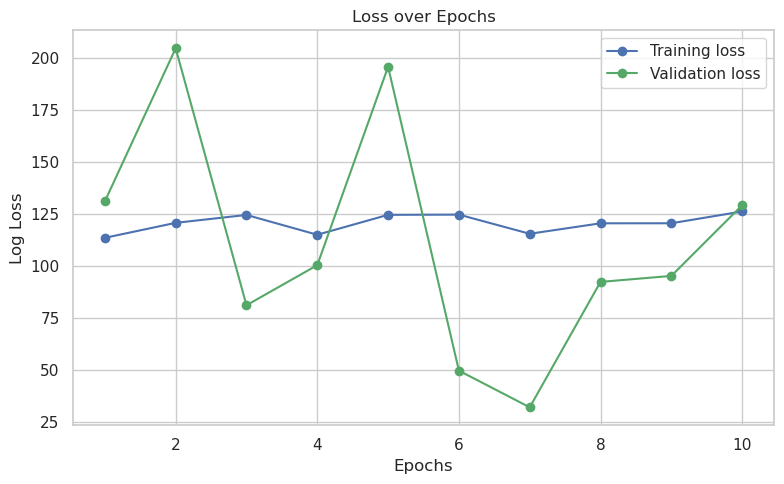

In [145]:
tf.random.set_seed(0)
# 2. Build and compile model
LR = 0.0001
model_tf = build_model(X_train.shape[1], learning_rate=LR)

# 3. Fit the model
# Do a single gradient update.
model_history = model_tf.fit(
    x=X_train,
    y=Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, Y_val),  # Validation data added
    verbose=0
)

# 4 Plot loss values
history_dict = model_history.history
history_dict.keys()

# Get the model Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a range of epoch numbers to match the length of the loss list
epochs = range(1, len(loss) + 1)  # Create a list of epochs starting from 1 to the number of epochs

# Plot the losses vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'go-', label='Validation loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.tight_layout()
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

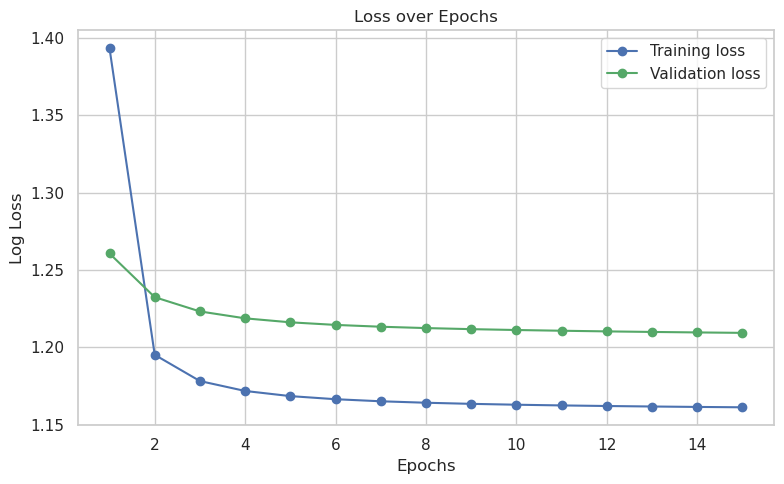

In [176]:
tf.random.set_seed(0)
# 2. Build and compile model
LR = 0.0000003
model_tf = build_model(X_train.shape[1], learning_rate=LR)

# 3. Fit the model
# Do a single gradient update.
model_history = model_tf.fit(
    x=X_train,
    y=Y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, Y_val),  # Validation data added
    verbose=0
)

# 4 Plot loss values
history_dict = model_history.history
history_dict.keys()

# Get the model Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a range of epoch numbers to match the length of the loss list
epochs = range(1, len(loss) + 1)  # Create a list of epochs starting from 1 to the number of epochs

# Plot the losses vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'go-', label='Validation loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.tight_layout()
plt.legend()
plt.show()

In [177]:
# 2. Print the first five learned parameters (including bias term)
weights, biases = model_tf.layers[0].get_weights()

print("First five learned weights (including bias term):")
print("Weights:", weights.flatten()[:4])  # Print first four weights
print("Bias:", biases[:1])  # Print bias (only one bias term in this case)

# 3. Print the loss at the final epoch on both training and validation datasets
final_train_loss = history_dict['loss'][-1]
final_val_loss = history_dict['val_loss'][-1]

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# 4. Calculate the percentage difference between the losses
percentage_difference = 100 * abs(final_train_loss - final_val_loss) / final_train_loss
print(f"\nPercentage Difference between Tuned Training and Validation Loss: {percentage_difference:.2f}%")

# 5. Compare with baseline model loss
# Assuming baseline_train_loss and baseline_val_loss were previously calculated
print(f"\nBaseline Training Loss: {train_log_loss:.4f}")
print(f"Baseline Validation Loss: {val_log_loss:.4f}")

# Determine if the TensorFlow model demonstrates an improvement over the baseline
train_loss_improvement = train_log_loss - final_train_loss
val_loss_improvement = val_log_loss - final_val_loss

print(f"\nImprovement in Training Loss: {train_loss_improvement:.4f}")
print(f"Improvement in Validation Loss: {val_loss_improvement:.4f}")

if final_val_loss < val_log_loss:
    print("\nThe TensorFlow model demonstrates an improvement over the baseline model.")
else:
    print("\nThe TensorFlow model does not demonstrate an improvement over the baseline model.")


First five learned weights (including bias term):
Weights: [0.9988211 0.9989072 0.9994947 1.0007404]
Bias: [0.99999994]

Final Training Loss: 1.1612
Final Validation Loss: 1.2094

Percentage Difference between Tuned Training and Validation Loss: 4.15%

Baseline Training Loss: 14.0143
Baseline Validation Loss: 14.3350

Improvement in Training Loss: 12.8531
Improvement in Validation Loss: 13.1257

The TensorFlow model demonstrates an improvement over the baseline model.


---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [178]:
# 1a. Get predicted probabilities for the training and test datasets
train_preds_prob = model_tf.predict(X_train)
test_preds_prob = model_tf.predict(X_test)

# 1b. Convert probabilities to class labels using argmax
train_preds_class = np.argmax(train_preds_prob, axis=1)
test_preds_class = np.argmax(test_preds_prob, axis=1)

# 1c.Calculate accuracy by comparing predicted labels with true labels
train_accuracy = accuracy_score(Y_train, train_preds_class)
test_accuracy = accuracy_score(Y_test, test_preds_class)

print(f"Aggregate Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Aggregate Test Accuracy: {test_accuracy * 100:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Aggregate Training Accuracy: 59.42%
Aggregate Test Accuracy: 54.32%


The training accuracy is 59.42%, while the test accuracy is 54.32%. The accuracies are fairly close, indicating that the model generalizes well to unseen data and isn't overfitted on the training data. However, the accuracy isn't very high as there is a cluster of data around class 4 of the cocoa percentage. In this case, it would be wise to apply a different machine learning technique.

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

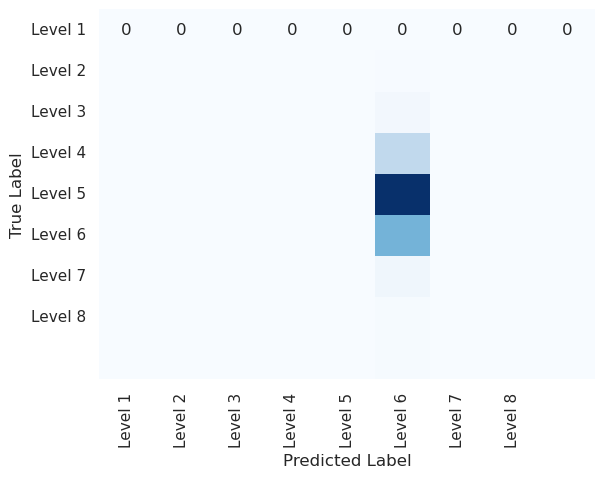

In [150]:
class_names = np.unique(Y)

cf = tf.math.confusion_matrix(Y_test, test_preds_class)
ax = sns.heatmap(cf, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels, yticklabels=labels, cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [151]:
# Count the occurrences of each class in Y_train
unique, counts = np.unique(Y_train, return_counts=True)
print("Class distribution in Y_train:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count}")

Class distribution in Y_train:
Class 1: 1
Class 2: 10
Class 3: 106
Class 4: 640
Class 5: 252
Class 6: 46
Class 7: 7
Class 8: 15


Class 5 has the most confusion as its commonly confused for class 6.

In [179]:
from sklearn.metrics import precision_score

# Calculate precision for each class
precision = precision_score(Y_test, test_preds_class, average=None)

# Find the class with the lowest precision
lowest_precision_class = np.argmin(precision)
lowest_precision_value = precision[lowest_precision_class]

print(f"Class with the lowest precision: {lowest_precision_class}")
print(f"Precision of the class: {lowest_precision_value:.4f}")

Class with the lowest precision: 0
Precision of the class: 0.0000


In [180]:
from sklearn.metrics import recall_score

# Calculate recall for each class
recall = recall_score(Y_test, test_preds_class, average=None)

# Find the class with the lowest recall
lowest_recall_class = np.argmin(recall)
lowest_recall_value = recall[lowest_recall_class]

print(f"Class with the lowest recall: {lowest_recall_class}")
print(f"Recall of the class: {lowest_recall_value:.4f}")

Class with the lowest recall: 0
Recall of the class: 0.0000


2. Class 0 has the least precision. Precision is the proportion of correctly predicted positive observations out of all observations predicted to be positive for each class. The class with the most false positives is class 0.
3. Class 0 has the least Recall. Recall is the measure of the proportion of correctly predicted positive observations out of all actual positive observations for each class.. The class with the most false negatives is class 0.

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [181]:
# YOUR CODE HERE